(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg Antibiotic

import Revise
# Import project package
import Antibiotic
# import tools to benchmark
import BenchmarkTools

# Import statistical functions
import Random
import StatsBase
import Distributions

# Import basic math
import LinearAlgebra

# Import ML libraries
import Flux
import Zygote

# Import library to perform tensor operations
using TensorOperations: @tensor

# Import differential equations solver
import DifferentialEquations as DiffEq

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.pboc_makie!()

# Differential geometry of latent space

`[explanation here]`

## Simple 3D example

To begin our exploration of the differential geometry ideas, let's work with a
simple example. Let us define a function of the form
$$
\underline{f}(x_1, x_2) =
\begin{bmatrix}
    x_{1}\\
    x_{2}\\
    \alpha \exp(- (x_{1}^2 + x_{2}^2))\\
\end{bmatrix}.
$$
This function will serve as our playground to have visual intuition about the
resulting latent space geometry.

In [2]:
# Define function
f(x₁, x₂) = 10 * exp(-(x₁^2 + x₂^2))

# Define complete vector function
f̲(x) = [x[1], x[2], f(x[1], x[2])]

f̲ (generic function with 1 method)

Let's generate a random set of numbers sampling points on the $x_1-x_2$ plane
that lie inside a circle of radius $r$. Furthermore, we will map these points to
3D space using our function $\underline{f}$.

In [3]:
Random.seed!(42)

# Define number of points to sample
n_sample = 1_000

# Defien radius
radius = 3

# Sample random radius
r_rand = radius .* sqrt.(Random.rand(n_sample))

# Sample random angles
θ_rand = 2π .* Random.rand(n_sample) 

# Convert form polar to cartesian coordinates
x_rand = Float32.(r_rand .* cos.(θ_rand))
y_rand = Float32.(r_rand .* sin.(θ_rand))
# Feed numbers to function
z_rand = f.(x_rand, y_rand)

# Compile data into matrix
data = Matrix(hcat(x_rand, y_rand, z_rand)')

3×1000 Matrix{Float32}:
 -1.1037    -0.130005  1.22947   …  -1.85835     2.19925     0.88909
  0.586526  -1.69648   0.903149     -1.71827    -1.69536     0.856582
  2.0968     0.553015  0.975618      0.0165177   0.00447911  2.17792

Now, let's take a look at both the input and output space for our function. We
will color the points by the $z$-value given by our function $\underline{f}$.

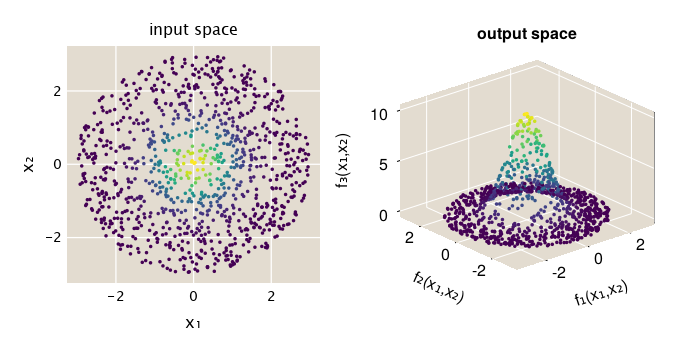

In [4]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add axis for input space
ax_input = Axis(
    gl[1, 1],
    xlabel="x₁",
    ylabel="x₂",
    title="input space"
)

# Plot input space
scatter!(
    ax_input,
    x_rand,
    y_rand,
    markersize=5,
    color=z_rand,
    colormpa=:viridis
)

# Add axis for output space
ax_output = Axis3(
    gl[1, 2],
    xlabel="f₁(x₁,x₂)",
    ylabel="f₂(x₁,x₂)",
    zlabel="f₃(x₁,x₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Plot output space
scatter!(
    ax_output,
    data[1, :],
    data[2, :],
    data[3, :],
    markersize=5,
    color=data[3, :],
    colormap=:viridis,
)

# Separate axis
colgap!(gl, 50)

fig

This looks like a very useful function on which to test the
differential-geometry ideas and gain visual intuition.

### Computing the Riemmanian metric

`[explanation here]`

Let's define a function to compute this Riemmanian metric using `Zygote.jl` for
the numerical differentiation.

In [5]:
@doc raw"""
    riemmanian_metric(manifold, val)

Function to compute the metric `M̲̲ = J̲̲ᵀJ̲̲` of a Riemmanian manifold via
numerical differentiation with `Zygote.jl`.

# Arguments
- `manifold::Function`: Function defining the manifold.
- `val::Vector{<:AbstractFloat}`: Value where to evaluate the metric.

# Returns
- `M̲̲::Matrix{<:AbstractFloat}`: Matrix evaluating the Riemmanian manifold
  metric.
"""
function riemmanian_metric(
    manifold::Function, val::AbstractVector{T}
)::Array{T} where T <: AbstractFloat
    # Compute Jacobian
    jac = first(Zygote.jacobian(manifold, val))
    # Initialize
    return jac' * jac
end # function


riemmanian_metric

Let's check how long it takes to estimate this Riemmanian metric numerically.

In [6]:
BenchmarkTools.@benchmark riemmanian_metric(f̲, [1.0, 1.0])

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  20.000 μs … 168.250 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     21.083 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   21.484 μs ±   3.797 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▆█▅ ▁▆▇▇▄                                                   
  ▂▇██████████▆▆▅▅▄▃▃▃▂▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  20 μs           Histogram: frequency by time         27.8 μs <

 Memory estimate: 6.78 KiB, allocs estimate: 203.

Let's test this function for a range of values on the latent space, computing
the square root of the determinant of the metric at each point as a measurement
of the local deformation on the manifold.

In [7]:
# Define numebr of points in range
n_range = 100

# Set range of values where to evaluate jacobian 
z1 = z2 = LinRange{Float32}(-radius * 1.1, radius * 1.1, n_range)

manifold_metric = sqrt.(
    LinearAlgebra.det.(
        [riemmanian_metric(f̲, collect(x)) for x in Iterators.product(z1, z2)]
    )
)

100×100 Matrix{Float32}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 ⋮                        ⋮              ⋱            ⋮                   
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

Now, let's plot this quantity bot on the input and output space to gain
intuition to what it represents.

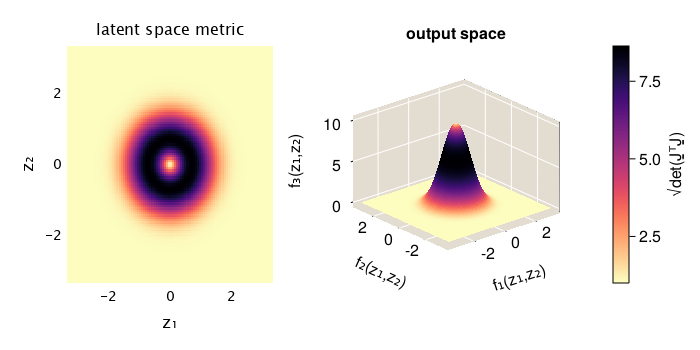

In [8]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add axis for latent space
ax1 = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric",
)

# Plot metric as a heatmap
hm = heatmap!(
    ax1, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Add axis for latent space
ax2 = Axis3(
    gl[1, 2],
    xlabel="f₁(z₁,z₂)",
    ylabel="f₂(z₁,z₂)",
    zlabel="f₃(z₁,z₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Evaluate function on grid
f_output = hcat(vec([f̲(collect(x)) for x in Iterators.product(z1, z2)])...)

# Plot surface
surface!(
    ax2, 
    eachrow(f_output)..., 
    colormap=Reverse(:magma), 
    color=vec(manifold_metric),
    colorrange=(minimum(manifold_metric), maximum(manifold_metric)),
    shading=false,
)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√det(J̲̲ᵀJ̲̲)") 

# Separate axis
colgap!(gl, 50)

fig

We can see that indeed the determinant of the metric captures the local
deformation of the manifold.

### Computing geodesics

`[explanation here]`

Defining the geodesic differential equations requires computing the so-called
[Christoffel symbols](https://en.wikipedia.org/wiki/Christoffel_symbols). For
this, we must evaluate the derivative of the Riemmanian metric as a function of
the coordinates on the latent space. Let's define such function to compute the
derivative numerically, again using `Zygote.jl` for automatic differentiation.

In [9]:
@doc raw"""
    ∂M̲̲∂γ̲(manifold, val, out_dim)

Function to compute the derivative of the Riemmanian metric `M̲̲` as a function
of the coordinates in the input space using `Zygote.jl`.

# Arguments
- `manifold::Function`: Function defining the manifold.
- `val::Vector{<:AbstractFloat}`: Value where to evaluate the metric.
- `out_dim::Int`: Dimensionality of the output space. This is required because
  `Zygote.jl` cannot compute the required derivatives automatically, but we have
  to "manually" iterate over the variables in the output space, one at the time.

# Returns
- `∂M̲̲::Array{<:AbstractFloat}`: Rank-3 tensor evaluating the derivative of the
  Riemmanian manifold metric.
"""
function ∂M̲̲∂γ̲(
    manifold::Function, val::Vector{T}, out_dim::Int
)::Array{T} where T <: AbstractFloat
    # Compute the manifold Jacobian. This should be a D×d matrix where D is the
    # dimension of the output space, and d is the dimension of the manifold.
    # Note that we use first() to extract the object we care about from the
    # Zygote output.
    J̲̲ = first(Zygote.jacobian(manifold, val))

    # Compute Hessian tensor, i.e., the tensor with the manifold second
    # derivatives. This should be a D×d×d third-order tensor, where D is the
    # dimension of the output space, and d is the dimension of the manifold.
    # Note that we have to manually evaluate the hessian on each dimension of
    # the output.
    H̲̲ = permutedims(
        cat(
            [Zygote.hessian(v -> manifold(v)[D], val) for D=1:out_dim]..., 
            dims=3
        ),
        (3, 1, 2)
    )

    # Compute the derivative of the Riemmanian metric. This should be a d×d×d
    # third-order tensor.
    return @tensor ∂M̲̲[i, j, k] := H̲̲[l, i, k] * J̲̲[l, j] + 
                                                   H̲̲[l, k, j] * J̲̲[l, i]
end # function

∂M̲̲∂γ̲

With this function in hand, we can compute the Christoffel symbols. Let's define
a function that returns this quantity.

In [10]:
@doc raw"""
    christoffel_symbols(manifold, val, out_dim)

Function to compute the Christoffel symbols from the Riemmanian metric `M̲̲` as
a function of the coordinates in the input space using `Zygote.jl`.

# Arguments
- `manifold::Function`: Function defining the manifold.
- `val::Vector{<:AbstractFloat}`: Value where to evaluate the metric.
- `out_dim::Int`: Dimensionality of the output space. This is required because
  `Zygote.jl` cannot compute the required derivatives automatically, but we have
  to "manually" iterate over the variables in the output space, one at the time.

# Returns
- `Γᵏᵢⱼ::Array{<:AbstractFloat}`: Rank-3 tensor evaluating the Christoffel
  symbols given a Riemmanian manifold metric.
"""
function christoffel_symbols(
    manifold::Function, val::Vector{T}, out_dim::Int
)::Array{T} where T <: AbstractFloat
    # Evaluate metric inverse
    M̲̲⁻¹ = LinearAlgebra.inv(riemmanian_metric(manifold, val))

    # Evaluate metric derivative
    ∂M̲̲ = ∂M̲̲∂γ̲(manifold, val, out_dim)

    # Compute Christoffel Symbols
    return @tensor Γᵏᵢⱼ[i, j, k] := (1 / 2) * M̲̲⁻¹[k, h] * 
    (∂M̲̲[i, h, j] + ∂M̲̲[j, h, i] - ∂M̲̲[i, j, h]) 
end # function

christoffel_symbols

Finally, with these functions in hand, we can define the 2nd order ODE system
defining the geodesic equations. This will be used by `DifferentialEquations.jl`
to numerically find geodesics.

In [11]:
@doc raw"""
    geodesic_system!(du, u, param, t)

Funtion thefining the right-hand side of the system of geodesic ODEs. The
function is evaluated in place⸺making `du` the first input⸺to accelerate the
integration. To define the 2nd order system of differential equtions we define a
system of coupled 1st order ODEs.

# Arguments
- `du::Array{<:AbstractFloat}`: derivatives of state variables. The first `end ÷
  2` entries define the velocity in latent space where the curve γ is being
  evaluated, i.e., dγ/dt. The second half defines the acceleration of the curve,
  i.e., d²γ/dt².
- `u::Array{<:AbstractFloat}`: State variables. The first `end ÷ 2` entries
  define the coordinates in latent space where the curve γ is being evaluated,
  i.e., γ. The second half defines the velocity of the curve, i.e., dγ/dt.
- `param::Dictionary`: Parameters required for the geodesic differential
  equation system and the boundary value integration. The list of required
  parameters are:
  - `in_dim::Int`: Dimensionality of input space.
  - `out_dim::Int`: Dimensionality of output space.
  - `manifold::Function`: Function definining the manifold.
  - `γ_init::Vector{<:AbstractFloat}`: Initial position in latent space.
  - `γ_end::Vector{<:AbstractFloat}`: Final position in latent space.
- `t::AbstractFloat`: Time where to evaluate the righ-hand side.
"""
function geodesic_system!(du, u, param, t)
    # Extract dimensions d and D
    in_dim, out_dim = param[:in_dim], param[:out_dim]
    # Extract manifold function
    manifold = param[:manifold]

    # Set curve coordinates 
    γ = u[1:in_dim] 
    # Set curve velocities
    dγ = u[in_dim+1:end]

    # Compute Christoffel symbols
    Γᵏᵢⱼ = christoffel_symbols(manifold, γ, out_dim)

    # Define the geodesic system of 2nd order ODEs
    @tensor d²γ[k] := - Γᵏᵢⱼ[i, j, k] * dγ[i] * dγ[j]

    # Update derivative values
    du .= [dγ; d²γ]
end # function

geodesic_system!

#### `Collocation` method for boundary value problems

The so-called [`collocation
method`](https://en.wikipedia.org/wiki/Collocation_method) to integrate between
a defined initial and final point requires a function that computes the
residuals between the current value of the function and the boundary conditions.
This will be used to set the integration such that it matches our desired
boundary conditions.

In [12]:
@doc raw"""
    boundary_condition!(residual, u, param, t)

Function that evaluates the residuals between the current position and the
desired boundary conditions.

# Arguments
- `residual::Vector{<:AbstractFloat}`: Array containing the residuals between
  the desired boundary conditions and the current state.
- `param::Dictionary`: Parameters required for the geodesic differential
  equation system and the boundary value integration. The list of required
  parameters are:
  - `in_dim::Int`: Dimensionality of input space.
  - `out_dim::Int`: Dimensionality of output space.
  - `manifold::Function`: Function definining the manifold.
  - `γ_init::Vector{<:AbstractFloat}`: Initial position in latent space.
  - `γ_end::Vector{<:AbstractFloat}`: Final position in latent space.
- `t::AbstractFloat`: Time where to evaluate the righ-hand side.
"""
function boundary_condition!(residual, u, param, t)
    # Extract parameters
    in_dim = param[:in_dim]

    # Compute residual for initial position
    @. residual[1:in_dim] = u[1][1:in_dim] - param[:γ_init]
    
    # Compute residual for final position
    @. residual[in_dim+1:end] = u[end][1:in_dim] - param[:γ_end]
end # function

boundary_condition!

Finally, we have everything in place to test this integration! Let us define the
required parameters as well as the `DifferentialEquations.jl` problem. For our
particular integration, we will use the `BVProblem` function to define our
boundary value problem.

In [13]:
# Define parameters
param = Dict(
    :in_dim => 2,
    :out_dim => 3,
    :manifold => f̲,
    :γ_init => [2.0, -2.0],
    :γ_end => [-2.0, 1.0]
)

# Define time span
tspan = (0.0, 1.0)

# Define boundary value problem
bvp = DiffEq.TwoPointBVProblem(
    geodesic_system!, 
    boundary_condition!,
    [param[:γ_init]; param[:γ_end] .- param[:γ_init]],
    tspan,
    param
)

BVProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 1.0)
u0: 4-element Vector{Float64}:
  2.0
 -2.0
 -4.0
  3.0

Now, let's integrate the geodesic differential equations!

In [14]:
# Solve system
sol = DiffEq.solve(bvp, DiffEq.MIRK4(), dt=0.05)

retcode: Success
Interpolation: 1st order linear
t: 21-element Vector{Float64}:
 0.0
 0.05
 0.1
 0.15
 0.2
 0.25
 0.3
 0.35
 0.4
 0.45
 ⋮
 0.6
 0.65
 0.7
 0.75
 0.8
 0.85
 0.9
 0.95
 1.0
u: 21-element Vector{Vector{Float64}}:
 [2.0, -2.0, -5.800569357154359, 0.9359044587913057]
 [1.7100563760644363, -1.9532943758258048, -5.795509360665774, 0.9303822184716138]
 [1.4208239438469457, -1.9074361978675685, -5.7665973256761776, 0.8939086229428991]
 [1.1345111517390156, -1.8656580470858375, -5.673345644205727, 0.753799727505683]
 [0.8542419717617746, -1.8340557016049204, -5.5410272277160555, 0.5071444931759147]
 [0.5789787541729924, -1.8128894676464387, -5.487831470312543, 0.37911888799556764]
 [0.30394311939638563, -1.7913167855659893, -5.521664185403741, 0.5320797844936063]
 [0.026795332863733097, -1.7553087344870522, -5.557232956810137, 0.9455746424877789]
 [-0.2504835595074319, -1.6937059558175915, -5.5162905223489584, 1.5423881407337725]
 [-0.5227245337528127, -1.5993260091844088, -5.349

It seems to have worked! Let's take a look at the resulting geodesic both in the
input and output space.

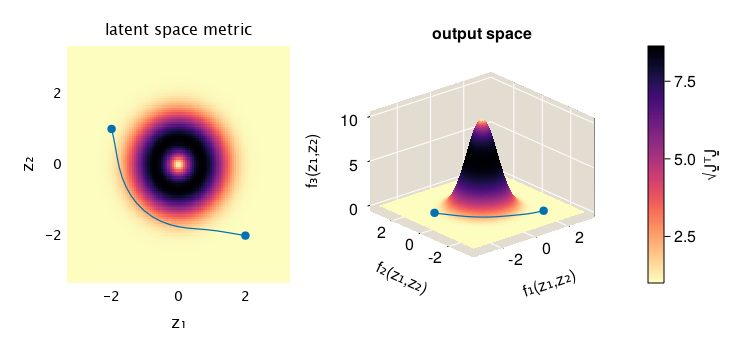

In [15]:
# Extract solutions into matrix
u = hcat(sol.u...)
# Split speed and coordinates
γ = u[1:param[:in_dim], :]
dγ = u[param[:in_dim]+1:end, :]

# Initialize figure
fig = Figure(resolution=(2.1 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add ax_inputis for latent space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Plot metric as a heatmap
hm = heatmap!(
    ax_input, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Plot geodesic
lines!(ax_input, eachrow(γ)...)
# Add initial and final points
scatter!(ax_input, eachrow(γ[:, [1, end]])...)

# Add axis for output space
ax_output = Axis3(
    gl[1, 2],
    xlabel="f₁(z₁,z₂)",
    ylabel="f₂(z₁,z₂)",
    zlabel="f₃(z₁,z₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Evaluate manifold on pairs of latent variables
f_output = hcat(f̲.(vec(collect(Iterators.product(z1, z2))))...)

# Plot surface
surface!(
    ax_output, 
    eachrow(f_output)..., 
    colormap=Reverse(:magma), 
    color=vec(manifold_metric),
    colorrange=(minimum(manifold_metric), maximum(manifold_metric)),
    shading=false,
)

# Evaluate geodesic in output space
γ_output = hcat([f̲(x) for x in eachcol(γ)]...)

# Plot geodesic line
lines!(ax_output, [x for x in eachrow(γ_output)]...)

# Add initial and final point
scatter!(ax_output, eachrow(γ_output[:, [1, end]])...)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√J̲̲ᵀJ̲̲") 

# Separate axis
colgap!(gl, 50)

fig

This looks great. Although the method is relatively slow, which might be
complicated if we want to scale this to a large number of points on the manifold
and all the possible pairs between them. Furthermore, the method is highly
unstable. Let's try to integrate the equation, slightly changing the final
point.

In [16]:
# Define parameters
param = Dict(
    :in_dim => 2,
    :out_dim => 3,
    :manifold => f̲,
    :γ_init => [2.0, -2.0],
    :γ_end => [-2.0, 1.9]
)

# Define time span
tspan = (0.0, 1.0)

# Define boundary value problem
bvp = DiffEq.TwoPointBVProblem(
    geodesic_system!, 
    boundary_condition!,
    [param[:γ_init]; param[:γ_end] .- param[:γ_init]],
    tspan,
    param
)

# Solve system
sol = DiffEq.solve(bvp, DiffEq.MIRK4(), dt=0.05)

retcode: Failure
Interpolation: 1st order linear
t: 21-element Vector{Float64}:
 0.0
 0.05
 0.1
 0.15
 0.2
 0.25
 0.3
 0.35
 0.4
 0.45
 ⋮
 0.6
 0.65
 0.7
 0.75
 0.8
 0.85
 0.9
 0.95
 1.0
u: 21-element Vector{Vector{Float64}}:
 [2.1655712979461192, -2.161878956850251, -4.252630496055341, 4.224399812551045]
 [2.1182712451298893, -2.112263448752731, -4.253165464334267, 4.224916780247369]
 [2.070775070710264, -2.062375556470819, -4.255037431344296, 4.226732811443501]
 [2.0230915660998856, -2.0121820638458137, -4.257890066415143, 4.2294888039549186]
 [1.9751954719920162, -1.9616145230265234, -4.26102606422198, 4.232485980417765]
 [1.9269731749477257, -1.910514903939433, -4.2630877136945085, 4.234371465103325]
 [1.878100057151761, -1.8585137195119144, -4.261449900172178, 4.2325428508058485]
 [1.827769638560456, -1.8047620172553303, -4.251017659368509, 4.2219726816404295]
 [1.7740994313418448, -1.7473446491575122, -4.221579945838582, 4.192628772802328]
 [1.7127789041179986, -1.681944552092131

Let's look at the resulting solution.

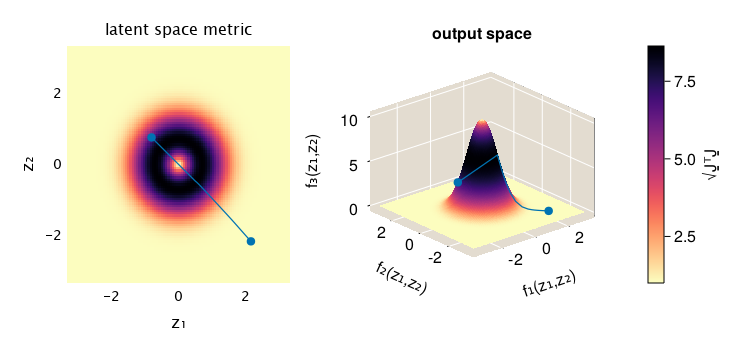

In [17]:
# Extract solutions into matrix
u = hcat(sol.u...)
# Split speed and coordinates
γ = u[1:param[:in_dim], :]
dγ = u[param[:in_dim]+1:end, :]

# Initialize figure
fig = Figure(resolution=(2.1 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add ax_inputis for latent space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Plot metric as a heatmap
hm = heatmap!(
    ax_input, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Plot geodesic
lines!(ax_input, eachrow(γ)...)
# Add initial and final points
scatter!(ax_input, eachrow(γ[:, [1, end]])...)

# Add axis for output space
ax_output = Axis3(
    gl[1, 2],
    xlabel="f₁(z₁,z₂)",
    ylabel="f₂(z₁,z₂)",
    zlabel="f₃(z₁,z₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Evaluate manifold on pairs of latent variables
f_output = hcat(f̲.(vec(collect(Iterators.product(z1, z2))))...)

# Plot surface
surface!(
    ax_output, 
    eachrow(f_output)..., 
    colormap=Reverse(:magma), 
    color=vec(manifold_metric),
    colorrange=(minimum(manifold_metric), maximum(manifold_metric)),
    shading=false,
)

# Evaluate geodesic in output space
γ_output = hcat([f̲(x) for x in eachcol(γ)]...)

# Plot geodesic line
lines!(ax_output, [x for x in eachrow(γ_output)]...)

# Add initial and final point
scatter!(ax_output, eachrow(γ_output[:, [1, end]])...)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√J̲̲ᵀJ̲̲") 

# Separate axis
colgap!(gl, 50)

fig

 By changing the initial conditions, the method greatly failed to converge to
 the true geodesic. Therefore, we must find an alternative method to compute
 these geodesics.

Let's explore the use of the so-called [`shooting
method`](https://en.wikipedia.org/wiki/Shooting_method) for boundary-value
problems.

#### `Shooting` method for boundary-value problems

Just as the `collocation` method required a function computing the residuals
between the current solution and the desired boundary conditions, the `shooting`
method requires the same. The difference is that rather than having a piece-wise
solution that we index as `u[1]` and `u[end]` for the initial and final point,
the shooting method returns a function we can evaluate. Therefore, our boundary
condition are set by evaluating the solution at `u(0.0)` and `u(1.0)` for our
time interval.

Let's define this condition.

In [18]:
function bc_shooting!(residual, u, param, t)
    # Extract parameters
    in_dim = param[:in_dim]

    # Compute residual for initial position
    @. residual[1:in_dim] = u(0.0)[1:in_dim] - param[:γ_init]
    # Compute residual for final position
    @. residual[in_dim+1:end] = u(1.0)[1:in_dim] - param[:γ_end]
end # function

bc_shooting! (generic function with 1 method)

Let's again define the dictionary of parameters we require for the integration
and run the shooting method via the `DifferentialEquations.Shooting` function.

In [19]:
# Define parameters
param = Dict(
    :in_dim => 2,
    :out_dim => 3,
    :manifold => f̲,
    :γ_init => [2.0, -2.0],
    :γ_end => [-2.0, 1.0]
)

# Define time span
tspan = (0.0, 1.0)

# Define boundary value problem
bvp = DiffEq.BVProblem(
    geodesic_system!, 
    bc_shooting!,
    [param[:γ_init]; param[:γ_end] .- param[:γ_init]],
    tspan,
    param
)

# Solve system
sol = DiffEq.solve(
    bvp, DiffEq.Shooting(DiffEq.AutoTsit5(DiffEq.Rosenbrock23()))
)
# sol = DiffEq.solve(bvp, DiffEq.Shooting(DiffEq.Vern7()))

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 32-element Vector{Float64}:
 0.0
 0.04664017946154166
 0.06980886733462265
 0.09514533436502659
 0.13148628886181113
 0.16060803417490252
 0.2101278551465796
 0.25838374929314567
 0.33012489612155566
 0.4099868967595016
 ⋮
 0.7853652587635562
 0.7999844959097878
 0.8178386057085025
 0.8392948532694117
 0.8656502397074091
 0.8963143557068427
 0.9300688343637981
 0.9782385762908556
 1.0
u: 32-element Vector{Vector{Float64}}:
 [1.9744305343793114, -1.9887137122538758, -10.26199841459287, 10.980700349835448]
 [1.50565193568889, -1.4863754652968089, -9.220692502825417, 9.947771693111514]
 [1.3239547898508803, -1.2872657712266176, -6.351472283302305, 7.136575664228347]
 [1.1956225876562738, -1.1379492955349353, -4.033727509955896, 4.903427937089157]
 [1.0804721895068352, -0.9893704865250545, -2.521146914562255, 3.4863043117345165]
 [1.0165364530915393, -0.

Let's look at the solution.

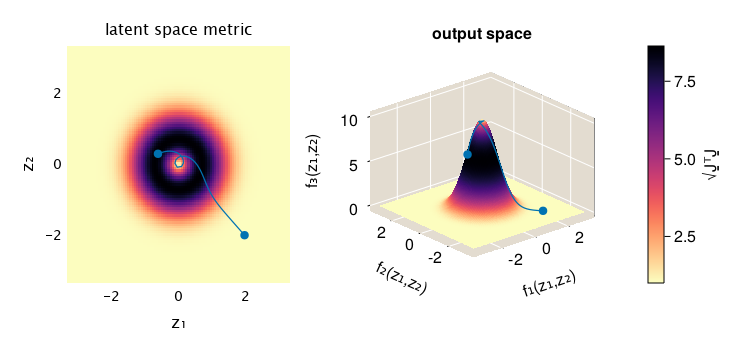

In [20]:
# Define linear range where to evaluate solution
t_range = LinRange(0, 1, 100)

# compute solution
u = hcat(sol.(t_range)...)
# Split speed and coordinates
γ = u[1:param[:in_dim], :]
dγ = u[param[:in_dim]+1:end, :]

# Initialize figure
fig = Figure(resolution=(2.1 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add ax_inputis for latent space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Plot metric as a heatmap
hm = heatmap!(
    ax_input, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Plot geodesic
lines!(ax_input, eachrow(γ)...)
# Add initial and final points
scatter!(ax_input, eachrow(γ[:, [1, end]])...)

# Add axis for output space
ax_output = Axis3(
    gl[1, 2],
    xlabel="f₁(z₁,z₂)",
    ylabel="f₂(z₁,z₂)",
    zlabel="f₃(z₁,z₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Evaluate manifold on pairs of latent variables
f_output = hcat(f̲.(vec(collect(Iterators.product(z1, z2))))...)

# Plot surface
surface!(
    ax_output, 
    eachrow(f_output)..., 
    colormap=Reverse(:magma), 
    color=vec(manifold_metric),
    colorrange=(minimum(manifold_metric), maximum(manifold_metric)),
    shading=false,
)

# Evaluate geodesic in output space
γ_output = hcat([f̲(x) for x in eachcol(γ)]...)

# Plot geodesic line
lines!(ax_output, [x for x in eachrow(γ_output)]...)

# Add initial and final point
scatter!(ax_output, eachrow(γ_output[:, [1, end]])...)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√J̲̲ᵀJ̲̲") 

# Separate axis
colgap!(gl, 50)

fig

We can see that even for the simple problem that the `collocation` method was
able to solve, the `shooting` method failed.

Either method, `collocation` or `shooting` can be much more efficient when given
a good initial condition for the velocity vector. Therefore, let us approximate
the initial velocity via splines.

## Initial condition via splines

In the `geodesic_spline.ipynb` notebook we implemented an algorithm to compute
energy-minimizing splines. Let's look at an example by fitting a spline between 
the points that the `shooting` method failed to connect.

In [21]:
# Set curve initial and final position
γ_init = [2.0, -2.0]
γ_end = [-2.0, 1.95]

# Define number of points for interpolation
n_points = 10_000

# Generate minimizing-energy spline
γ_spline = Antibiotic.diffgeo.min_energy_spline(
    γ_init, γ_end, f̲, n_points; tol=1E-2
)

2×8758 Matrix{Float64}:
  2.0   1.996     1.99201   1.98802  …  -1.99654  -1.99655  -1.99655
 -2.0  -1.99605  -1.99211  -1.98817      1.94059   1.9406    1.94061

Let's compute the length of the resulting curve.

In [22]:
println("Length: $(Antibiotic.diffgeo.curve_length(γ_spline, f̲))")

Length: 7.574568640930301


Now, let's look at the solution.

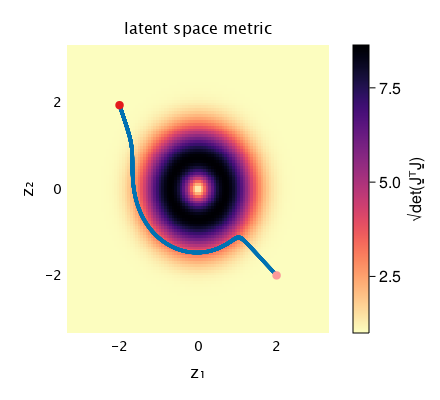

In [23]:
# Initialize figure
fig = Figure(resolution=(1.1 * 400, 400))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add ax_inputis for latent space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Plot metric as a heatmap
hm = heatmap!(
    ax_input, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Add optimized curve
scatterlines!(ax_input, eachrow(γ_spline)..., markersize=5)

# Add initial and final points
scatter!(ax_input, γ_spline[1:2, 1]..., color=ColorSchemes.Paired_9[5])
scatter!(ax_input, γ_spline[1:2, end]..., color=ColorSchemes.Paired_9[6])

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√det(J̲̲ᵀJ̲̲)") 

fig

The method indeed creates a very good approximation of the true spline, but it
fails due to the unrestricted optimization the algorithm is performing.
Nevertheless, notice that the last part of the trajectory towards the final
point (darker red shade) looks like it has the correct direction. Let's take a
look at the direction of these estimates of the curve derivative. For this, we
will reverse the order of the points.

Furthermore, to compute the appropriate derivative, we must take into account
the separation of points along the curve not in the latent space but in the
output space. Assuming that our spline method approximates a geodesic, and a
geodesic is a curve that travels at constant speed on the output space, we can
determine the $\Delta t$ denominator when computing the discrete derivative
$$
\frac{\Delta \underline{\gamma}}{\Delta t} \approx
\frac{d \underline{\gamma}}{d t},
$$
more accurately.

In [24]:
# Reverse order of spline points
γ_rev = reverse(γ_spline, dims=2)

# Compute the finite derivatives along the entire curve.
δγ = diff(γ_rev, dims=2)

# Compute the lengths on data space for each small section
δx = Antibiotic.diffgeo.curve_lengths(γ_rev, f̲)

# Compute the time intervals assuming that the curve was travelled at uniform
# speed in output space
δt = δx ./ sum(δx)

# Compute the finite curve velocities on input space
δγδt = hcat([δγ[:, i] ./ δt[i] for i = 1:length(δt)]...)

2×8757 Matrix{Float64}:
  2.60957   2.60957   2.60957   2.60957  …   5.38508   5.38514   5.3852
 -7.10381  -7.10381  -7.10381  -7.10381     -5.31774  -5.3178   -5.31786

Let's plot the resulting finite velocities, representing them as small arrows.

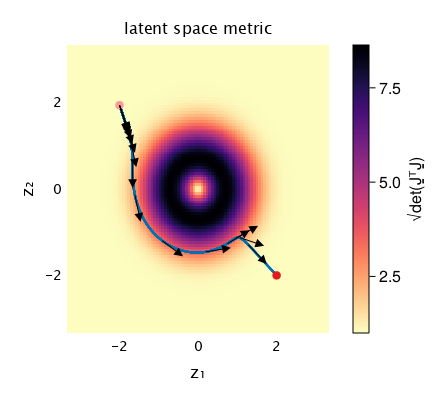

In [25]:
# Initialize figure
fig = Figure(resolution=(1.1 * 400, 400))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add ax_inputis for latent space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Plot metric as a heatmap
hm = heatmap!(
    ax_input, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Add optimized curve
scatterlines!(ax_input, eachrow(γ_rev)..., markersize=3)

# Add initial and final points
scatter!(ax_input, γ_rev[1:2, 1]..., color=ColorSchemes.Paired_9[5])
scatter!(ax_input, γ_rev[1:2, end]..., color=ColorSchemes.Paired_9[6])

# Define how often to plot arrows
n_range = 500
# Select subset of velocities
δγ_subset = δγδt[:, 1:n_range:end] 
# Compute unitary velocity vectors
δγ_subset = hcat(
    [
        δγ_subset[:, i] ./ LinearAlgebra.norm.(eachcol(δγ_subset))[i] ./ 2
        for i = 1:size(δγ_subset, 2)
    ]...
)
# # Select subset to plot arrows
γ_subset = γ_rev[:, 1:n_range:end]
# Adjust number acoording to number of δγ_subset (since diff has one less
# element)
γ_subset = γ_subset[:, 1:1:size(δγ_subset, 2)]

# Add arrows indicating the instantaneous velocity
arrows!(ax_input, eachrow(γ_subset)..., eachrow(δγ_subset)..., color=:black)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√det(J̲̲ᵀJ̲̲)") 

fig

We see that indeed these discretized velocities go in the right direction. Let's
use this estimate of the initial velocity for our `shooting` method problem.

In [26]:
# Define parameters
param = Dict(
    :in_dim => 2,
    :out_dim => 3,
    :manifold => f̲,
    :γ_end => [2.0, -2.0],   # Notice the change in order
    :γ_init => [-2.0, 1.95], # Notice the change in order
)

# Define time span
tspan = (0.0, 1.0)

# Define boundary value problem
bvp = DiffEq.TwoPointBVProblem(
    geodesic_system!, 
    bc_shooting!,
    [param[:γ_init]; δγδt[:, 1]],
    tspan,
    param
)

# Solve system
sol = DiffEq.solve(
    bvp, DiffEq.Shooting(DiffEq.AutoTsit5(DiffEq.Rosenbrock23()))
)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 12-element Vector{Float64}:
 0.0
 0.08948313878416245
 0.1698705591027185
 0.2317928177799801
 0.31360028446623367
 0.38831307588101155
 0.5025123234822898
 0.6230443304252901
 0.7472410648516254
 0.8551143402196105
 0.9550467311790567
 1.0
u: 12-element Vector{Vector{Float64}}:
 [-2.0, 1.95, 1.1569954928694037, -6.706214154324548]
 [-1.8980975347340876, 1.3512548412224146, 1.0840581838374208, -6.649356196893319]
 [-1.8274881385807273, 0.8268254568108064, 0.6118358056976038, -6.3815361751450626]
 [-1.7958748512501013, 0.43429691819544697, 0.5205026230758261, -6.338055402996355]
 [-1.7242791737680143, -0.08777286106081623, 1.3883322593222855, -6.399471942951689]
 [-1.5713375226402133, -0.5584052424840301, 2.75642699199202, -6.120343474641983]
 [-1.1292316443094346, -1.187829340800979, 4.915105830393976, -4.709328900172615]
 [-0.44357675367267485, -1.6

Let's look at the solution.

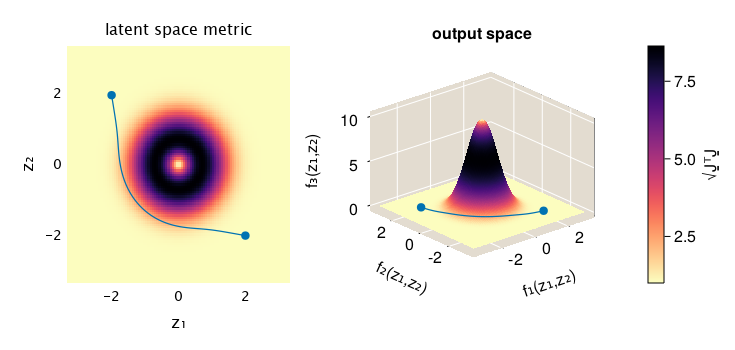

In [27]:
# Define linear range where to evaluate solution
t_range = LinRange(0, 1, 100)

# compute solution
u = hcat(sol.(t_range)...)
# Split speed and coordinates
γ = u[1:param[:in_dim], :]
dγ = u[param[:in_dim]+1:end, :]

# Initialize figure
fig = Figure(resolution=(2.1 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add ax_inputis for latent space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Plot metric as a heatmap
hm = heatmap!(
    ax_input, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Plot geodesic
lines!(ax_input, eachrow(γ)...)
# Add initial and final points
scatter!(ax_input, eachrow(γ[:, [1, end]])...)

# Add axis for output space
ax_output = Axis3(
    gl[1, 2],
    xlabel="f₁(z₁,z₂)",
    ylabel="f₂(z₁,z₂)",
    zlabel="f₃(z₁,z₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Evaluate manifold on pairs of latent variables
f_output = hcat(f̲.(vec(collect(Iterators.product(z1, z2))))...)

# Plot surface
surface!(
    ax_output, 
    eachrow(f_output)..., 
    colormap=Reverse(:magma), 
    color=vec(manifold_metric),
    colorrange=(minimum(manifold_metric), maximum(manifold_metric)),
    shading=false,
)

# Evaluate geodesic in output space
γ_output = hcat([f̲(x) for x in eachcol(γ)]...)

# Plot geodesic line
lines!(ax_output, [x for x in eachrow(γ_output)]...)

# Add initial and final point
scatter!(ax_output, eachrow(γ_output[:, [1, end]])...)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√J̲̲ᵀJ̲̲") 

# Separate axis
colgap!(gl, 50)

fig

The shooting method now converged to the true geodesic!

Let's try doing the same thing, this time with the collocation method.

In [28]:
# Define parameters
param = Dict(
    :in_dim => 2,
    :out_dim => 3,
    :manifold => f̲,
    :γ_end => [2.0, -2.0],   # Notice the change in order
    :γ_init => [-2.0, 1.95], # Notice the change in order
)

# Define time span
tspan = (0.0, 1.0)

# Define boundary value problem
bvp = DiffEq.TwoPointBVProblem(
    geodesic_system!, 
    boundary_condition!,
    [param[:γ_init]; δγδt[:, 1]],
    tspan,
    param
)


# Solve system
sol = DiffEq.solve(bvp, DiffEq.MIRK4(), dt=0.05)

retcode: Success
Interpolation: 1st order linear
t: 21-element Vector{Float64}:
 0.0
 0.05
 0.1
 0.15
 0.2
 0.25
 0.3
 0.35
 0.4
 0.45
 ⋮
 0.6
 0.65
 0.7
 0.75
 0.8
 0.85
 0.9
 0.95
 1.0
u: 21-element Vector{Vector{Float64}}:
 [-2.0, 1.95, 1.1580164693758028, -6.707270718130589]
 [-1.942295716378304, 1.6148158692552348, 1.1452067180731071, -6.696048998934405]
 [-1.886751042578119, 1.2813314409600118, 1.0507159487688678, -6.626589135528604]
 [-1.8409543881627795, 0.9541677312692656, 0.7510955477428238, -6.449413708887649]
 [-1.811243695647997, 0.6353657384924298, 0.483534411357207, -6.329148926709797]
 [-1.785415375066226, 0.31853509404810354, 0.6263675704412789, -6.360383194007558]
 [-1.7416299252460683, -0.0008789390718838413, 1.1833679173025584, -6.405122533164364]
 [-1.6624667864146767, -0.3198131707055143, 2.017447193342017, -6.322636609113167]
 [-1.5375792457894708, -0.6296241556834398, 2.990490188767867, -6.031223225705559]
 [-1.3631762501492932, -0.9189401962536066, 3.9787016492

Again, let's look at the solution.

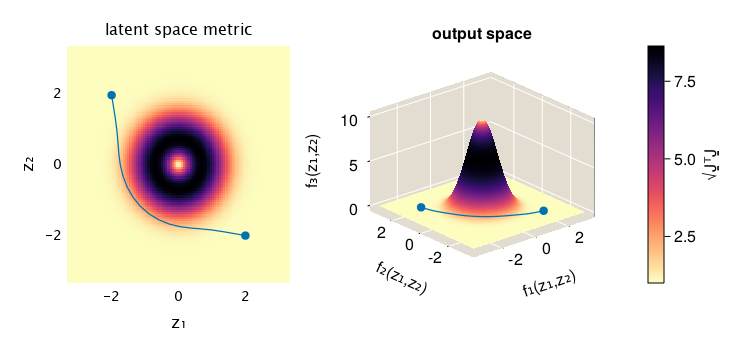

In [29]:
# Extract solutions into matrix
u = hcat(sol.u...)
# Split speed and coordinates
γ = u[1:param[:in_dim], :]
dγ = u[param[:in_dim]+1:end, :]

# Initialize figure
fig = Figure(resolution=(2.1 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add ax_inputis for latent space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Plot metric as a heatmap
hm = heatmap!(
    ax_input, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Plot geodesic
lines!(ax_input, eachrow(γ)...)
# Add initial and final points
scatter!(ax_input, eachrow(γ[:, [1, end]])...)

# Add axis for output space
ax_output = Axis3(
    gl[1, 2],
    xlabel="f₁(z₁,z₂)",
    ylabel="f₂(z₁,z₂)",
    zlabel="f₃(z₁,z₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Evaluate manifold on pairs of latent variables
f_output = hcat(f̲.(vec(collect(Iterators.product(z1, z2))))...)

# Plot surface
surface!(
    ax_output, 
    eachrow(f_output)..., 
    colormap=Reverse(:magma), 
    color=vec(manifold_metric),
    colorrange=(minimum(manifold_metric), maximum(manifold_metric)),
    shading=false,
)

# Evaluate geodesic in output space
γ_output = hcat([f̲(x) for x in eachcol(γ)]...)

# Plot geodesic line
lines!(ax_output, [x for x in eachrow(γ_output)]...)

# Add initial and final point
scatter!(ax_output, eachrow(γ_output[:, [1, end]])...)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√J̲̲ᵀJ̲̲") 

# Separate axis
colgap!(gl, 50)

fig

This worked as well! We therefore now have a robust method to compute geodesics
and energy-minimizing curves on Riemmanian manifolds.